In [1]:
# Import my own classes
import Prot_Post as Post
import OCTP_postprocess_CLASS as octp
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
from typing import Tuple

from IPython import get_ipython

def set_inline():
    """Set the Matplotlib backend to inline for Jupyter Notebook."""
    get_ipython().run_line_magic("matplotlib", "inline")
    Post.set_plot_settings(tex=False, svg=False)
    print("Switched to Inline Renderer")

def set_svg():
    """Set the Matplotlib backend to SVG for saving high-quality images."""
    Post.set_plot_settings(tex=True, svg=True)
    print("Switched to SVG Renderer")

In [2]:
set_inline()

Switched to Inline Renderer


In [3]:
def msd_log_spaced(t, msd, steps=2000, t_min: float=5e0, t_max: float=4e5, ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the mean squared displacement (MSD) at logarithmically spaced time intervals.

    Parameters
    ----------
    t : np.ndarray
        Array of time values.
    msd : np.ndarray
        Array of mean squared displacement values corresponding to the time values.
    steps : int, optional
        Number of logarithmically spaced steps. Default is 2000.
    t_min : float, optional
        Minimum time value for logarithmic spacing. Default is 5e2.
    t_max : float, optional
        Maximum time value for logarithmic spacing. Default is 4e5.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Tuple containing:
        - t_log (np.ndarray): Logarithmically spaced time values.
        - msd_log (np.ndarray): MSD values corresponding to the logarithmically spaced time values.
    """
    n = np.unique(np.logspace(np.log10(t_min), np.log10(t_max), steps, dtype=int))
    n = n[n < t.shape[0]]  # avoid out of bounds
    
    t_log = t[n]
    msd_log = msd[n]
    
    mask = (t_log >= t_min) & (t_log <= t_max)
    t_log = t_log[mask]*1e-3  # convert from fs to ps
    msd_log = msd_log[mask]  # still in A^2
    return t_log, msd_log

# MLMD simulations
load all statepoints in our system.

In [4]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD/"

OH_msd = [None]*Ts_C.size
K_msd = [None]*Ts_C.size

OH_msd_log = [None]*(Ts_C.size*len(runs)+1)
K_msd_log = [None]*(Ts_C.size*len(runs)+1)
header = "t "

In [5]:
t_as_well = True

k = 1
for j, T_C in enumerate(Ts_C):
    OH_msd_temp = []
    K_msd_temp = []
    for i, run in enumerate(runs):
        post = Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run, verbose=False)
        OH_msd_temp.append(post.msd_OH)
        K_msd_temp.append(post.msd_K)
        
        t, msd = msd_log_spaced(post.t, post.msd_OH, steps=250, t_min=.1, t_max=1e6)
        if t_as_well == True:
            OH_msd_log[0] = t
        OH_msd_log[k] = msd

        t, msd = msd_log_spaced(post.t, post.msd_K, steps=250, t_min=.1, t_max=1e6)
        
        if t_as_well == True:
            K_msd_log[0] = t
        K_msd_log[k] = msd
        t_as_well = False
        
        header += r"T_"+str(T_C)+r"_r_"+str(i+1)+r" "
        k += 1

    OH_msd[j] = OH_msd_temp
    K_msd[j] = K_msd_temp

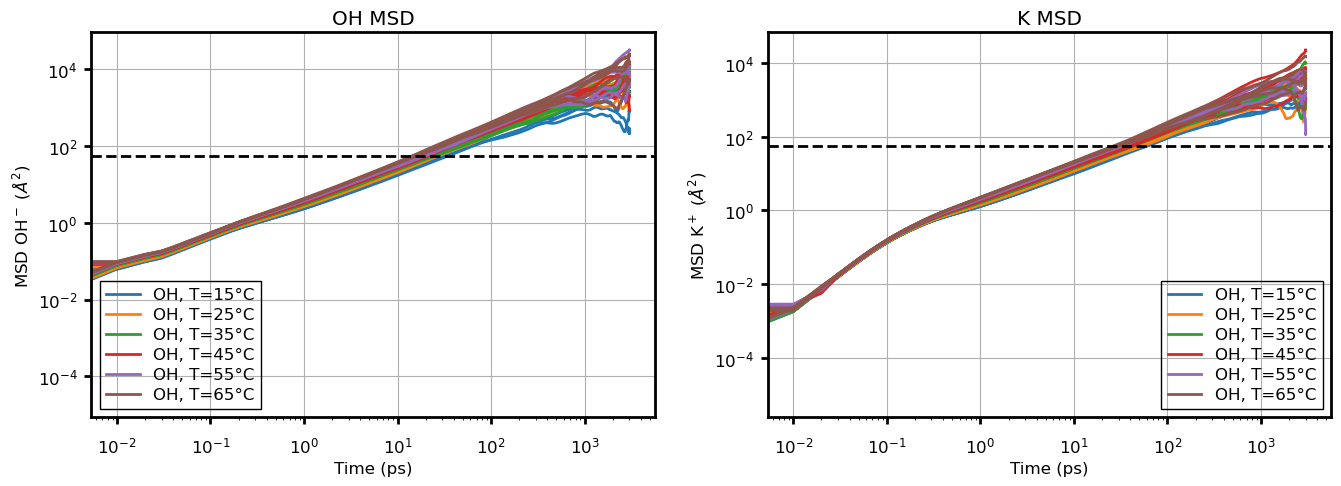

In [6]:
fig, axs = plt.subplots(1, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j, T_C in enumerate(Ts_C):
    labels = True
    for i, run in enumerate(runs):
        label = r"OH, T="+str(T_C)+r"°C" if labels else None
        labels = False
        axs[0].plot(post.t/1000, OH_msd[j][i], label=label, color=colors[j])
        axs[1].plot(post.t/1000, K_msd[j][i], label=label, color=colors[j])

axs[0].set_title("OH MSD")
axs[0].axhline(y=55.5, color='black', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel(r"MSD OH$^-$ ($\AA^2$)")
axs[0].grid()
axs[0].legend()

axs[1].set_title("K MSD")
axs[1].axhline(y=55.5, color='black', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel(r"MSD K$^+$ ($\AA^2$)")
axs[1].grid()
axs[1].legend()

In [7]:
OH_msd_log = np.vstack(OH_msd_log).T
np.savetxt("plot5/OH_msd_mlmd_uH1.text", OH_msd_log, header=header, comments="")
K_msd_log = np.vstack(K_msd_log).T
np.savetxt("plot5/K_msd_mlmd_uH1.text", K_msd_log, header=header, comments="")

# HEAVY WATER SIMULATIONS uH=2

In [8]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD_heavy/"

OH_msd = [None]*Ts_C.size
K_msd = [None]*Ts_C.size

OH_msd_log = [None]*(Ts_C.size*len(runs)+1)
K_msd_log = [None]*(Ts_C.size*len(runs)+1)
header = "t "

In [9]:
t_as_well = True

k = 1
for j, T_C in enumerate(Ts_C):
    OH_msd_temp = []
    K_msd_temp = []
    for i, run in enumerate(runs):
        post = Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run+"part_uH_2", verbose=False)
        OH_msd_temp.append(post.msd_OH)
        K_msd_temp.append(post.msd_K)
        
        t, msd = msd_log_spaced(post.t, post.msd_OH, steps=250, t_min=.1, t_max=1e6)
        if t_as_well == True:
            OH_msd_log[0] = t
        OH_msd_log[k] = msd

        t, msd = msd_log_spaced(post.t, post.msd_K, steps=250, t_min=.1, t_max=1e6)
        
        if t_as_well == True:
            K_msd_log[0] = t
        K_msd_log[k] = msd
        t_as_well = False
        
        header += r"T_"+str(T_C)+r"_r_"+str(i+1)+r" "
        k += 1

    OH_msd[j] = OH_msd_temp
    K_msd[j] = K_msd_temp

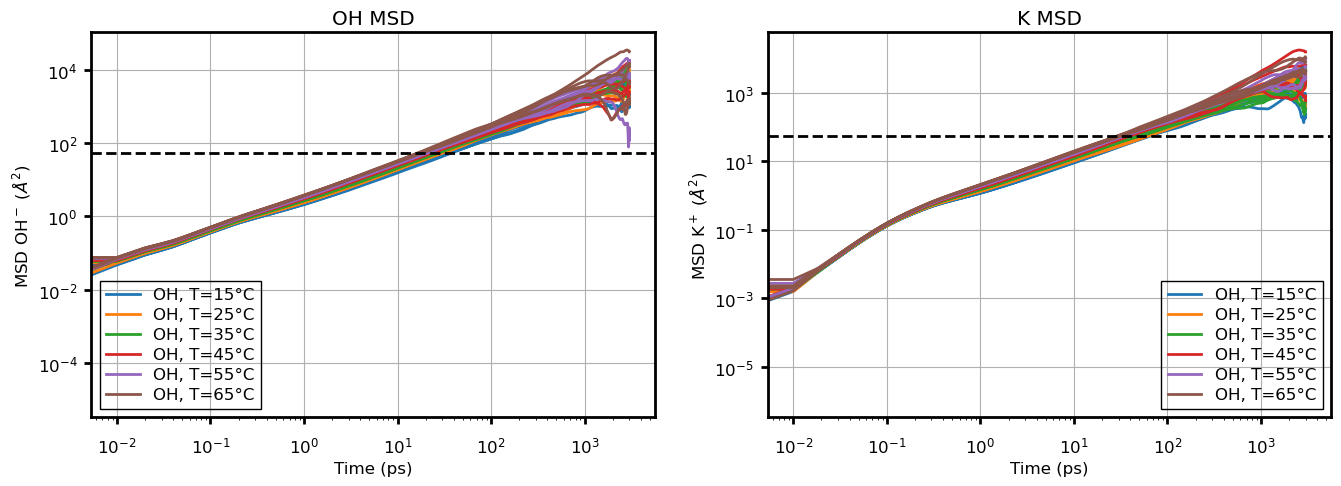

In [10]:
fig, axs = plt.subplots(1, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j, T_C in enumerate(Ts_C):
    labels = True
    for i, run in enumerate(runs):
        label = r"OH, T="+str(T_C)+r"°C" if labels else None
        labels = False
        axs[0].plot(post.t/1000, OH_msd[j][i], label=label, color=colors[j])
        axs[1].plot(post.t/1000, K_msd[j][i], label=label, color=colors[j])

axs[0].set_title("OH MSD")
axs[0].axhline(y=55.5, color='black', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel(r"MSD OH$^-$ ($\AA^2$)")
axs[0].grid()
axs[0].legend()

axs[1].set_title("K MSD")
axs[1].axhline(y=55.5, color='black', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel(r"MSD K$^+$ ($\AA^2$)")
axs[1].grid()
axs[1].legend()

In [11]:
OH_msd_log = np.vstack(OH_msd_log).T
np.savetxt("plot5/OH_msd_mlmd_uH2.text", OH_msd_log, header=header, comments="")
K_msd_log = np.vstack(K_msd_log).T
np.savetxt("plot5/K_msd_mlmd_uH2.text", K_msd_log, header=header, comments="")

# HEAVY WATER SIMULATIONS uH=3

In [12]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD_heavy/"

OH_msd = [None]*Ts_C.size
K_msd = [None]*Ts_C.size

OH_msd_log = [None]*(Ts_C.size*len(runs)+1)
K_msd_log = [None]*(Ts_C.size*len(runs)+1)
header = "t "

In [13]:
t_as_well = True

k = 1
for j, T_C in enumerate(Ts_C):
    OH_msd_temp = []
    K_msd_temp = []
    for i, run in enumerate(runs):
        post = Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run+"part_uH_3", verbose=False)
        OH_msd_temp.append(post.msd_OH)
        K_msd_temp.append(post.msd_K)
        
        t, msd = msd_log_spaced(post.t, post.msd_OH, steps=250, t_min=.1, t_max=1e6)
        if t_as_well == True:
            OH_msd_log[0] = t
        OH_msd_log[k] = msd

        t, msd = msd_log_spaced(post.t, post.msd_K, steps=250, t_min=.1, t_max=1e6)
        
        if t_as_well == True:
            K_msd_log[0] = t
        K_msd_log[k] = msd
        t_as_well = False
        
        header += r"T_"+str(T_C)+r"_r_"+str(i+1)+r" "
        k += 1

    OH_msd[j] = OH_msd_temp
    K_msd[j] = K_msd_temp

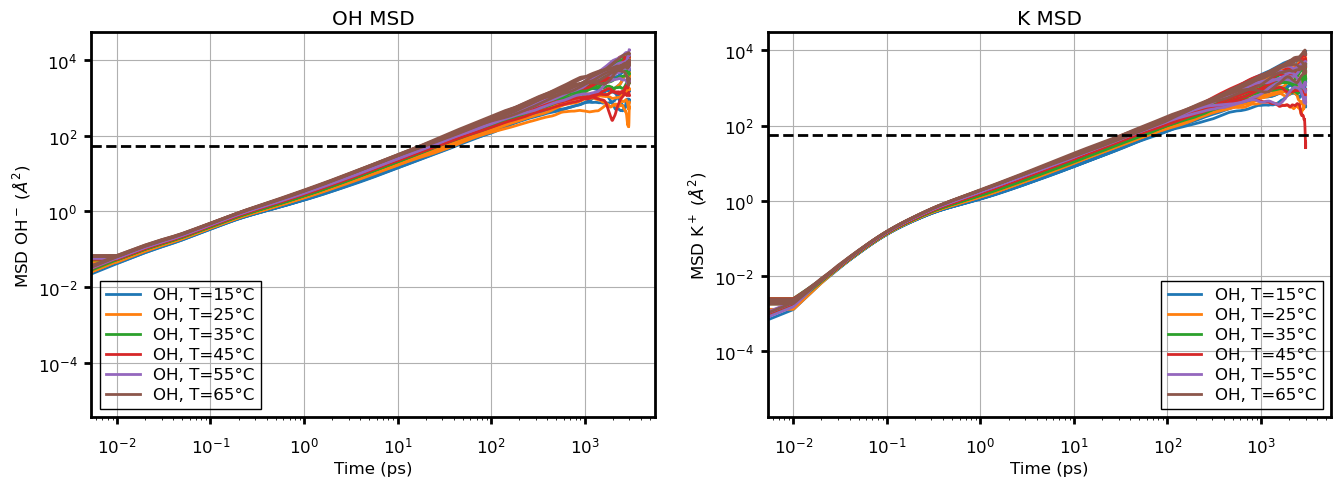

In [14]:
fig, axs = plt.subplots(1, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j, T_C in enumerate(Ts_C):
    labels = True
    for i, run in enumerate(runs):
        label = r"OH, T="+str(T_C)+r"°C" if labels else None
        labels = False
        axs[0].plot(post.t/1000, OH_msd[j][i], label=label, color=colors[j])
        axs[1].plot(post.t/1000, K_msd[j][i], label=label, color=colors[j])

axs[0].set_title("OH MSD")
axs[0].axhline(y=55.5, color='black', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel(r"MSD OH$^-$ ($\AA^2$)")
axs[0].grid()
axs[0].legend()

axs[1].set_title("K MSD")
axs[1].axhline(y=55.5, color='black', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel(r"MSD K$^+$ ($\AA^2$)")
axs[1].grid()
axs[1].legend()

In [15]:
OH_msd_log = np.vstack(OH_msd_log).T
np.savetxt("plot5/OH_msd_mlmd_uH3.text", OH_msd_log, header=header, comments="")
K_msd_log = np.vstack(K_msd_log).T
np.savetxt("plot5/K_msd_mlmd_uH3.text", K_msd_log, header=header, comments="")

# Heavy water simulations uH=10

In [16]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
temps = [r"Temp_"+str(T)+"/" for T in Ts_C]
base_dir = r"MLMD_heavy/"

OH_msd = [None]*Ts_C.size
K_msd = [None]*Ts_C.size

OH_msd_log = [None]*(Ts_C.size*len(runs)+1)
K_msd_log = [None]*(Ts_C.size*len(runs)+1)
header = "t "

In [17]:
t_as_well = True

k = 1
for j, T_C in enumerate(Ts_C):
    OH_msd_temp = []
    K_msd_temp = []
    for i, run in enumerate(runs):
        post = Post.Prot_Post(base_dir+r"Temp_"+str(T_C)+"/"+run+"part_uH_10", verbose=False)
        OH_msd_temp.append(post.msd_OH)
        K_msd_temp.append(post.msd_K)
        
        t, msd = msd_log_spaced(post.t, post.msd_OH, steps=250, t_min=.1, t_max=1e6)
        if t_as_well == True:
            OH_msd_log[0] = t
        OH_msd_log[k] = msd

        t, msd = msd_log_spaced(post.t, post.msd_K, steps=250, t_min=.1, t_max=1e6)
        
        if t_as_well == True:
            K_msd_log[0] = t
        K_msd_log[k] = msd
        t_as_well = False
        
        header += r"T_"+str(T_C)+r"_r_"+str(i+1)+r" "
        k += 1

    OH_msd[j] = OH_msd_temp
    K_msd[j] = K_msd_temp

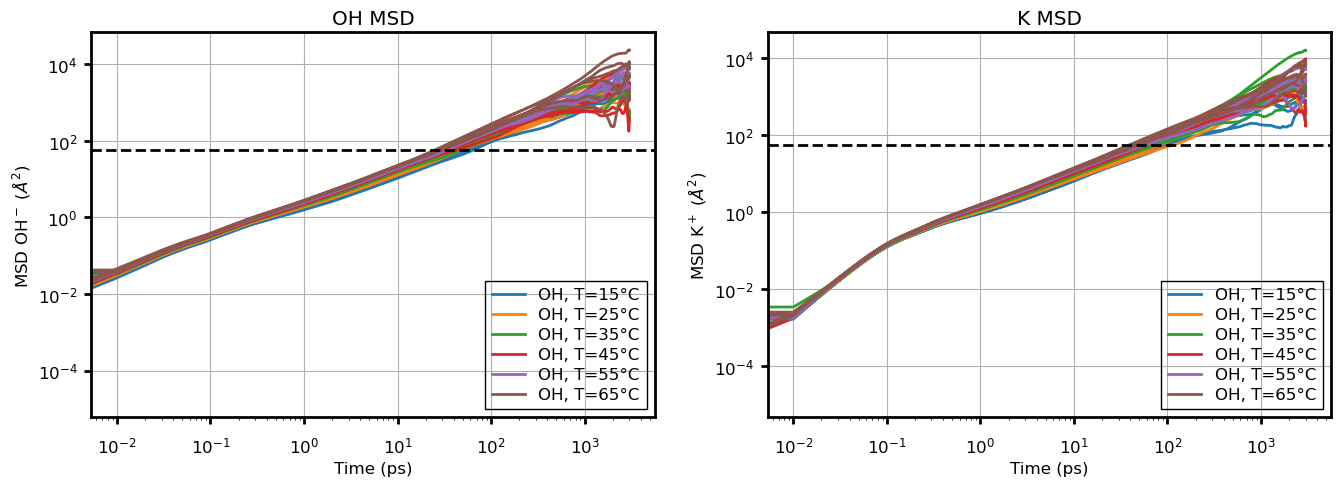

In [18]:
fig, axs = plt.subplots(1, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j, T_C in enumerate(Ts_C):
    labels = True
    for i, run in enumerate(runs):
        label = r"OH, T="+str(T_C)+r"°C" if labels else None
        labels = False
        axs[0].plot(post.t/1000, OH_msd[j][i], label=label, color=colors[j])
        axs[1].plot(post.t/1000, K_msd[j][i], label=label, color=colors[j])

axs[0].set_title("OH MSD")
axs[0].axhline(y=55.5, color='black', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel(r"MSD OH$^-$ ($\AA^2$)")
axs[0].grid()
axs[0].legend()

axs[1].set_title("K MSD")
axs[1].axhline(y=55.5, color='black', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel(r"MSD K$^+$ ($\AA^2$)")
axs[1].grid()
axs[1].legend()

In [19]:
OH_msd_log = np.vstack(OH_msd_log).T
np.savetxt("plot5/OH_msd_mlmd_uH10.text", OH_msd_log, header=header, comments="")
K_msd_log = np.vstack(K_msd_log).T
np.savetxt("plot5/K_msd_mlmd_uH10.text", K_msd_log, header=header, comments="")

# CMD simulations

In [20]:
base_dir = 'CMD/'
groups = ['wat', 'Oh', 'K']
Ts_C = np.arange(15, 66, 10, dtype=np.int32)

runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]

OH_msd = [None]*Ts_C.size
K_msd = [None]*Ts_C.size

OH_msd_log = [None]*(Ts_C.size*len(runs)+1)
K_msd_log = [None]*(Ts_C.size*len(runs)+1)
header = "t "

t_as_well = True
k=1
for j, T_C in enumerate(Ts_C):
    mixture = octp.PP_OCTP(base_dir+r"Temp_"+str(T_C)+"/", runs, groups=groups, dt=1, plotting=False)

    # Change the file names
    mixture.filenames(Diff_Onsag='diffonsag.dat',
                      T_conduc='tconductivity.dat',
                      Diff_self='diffself.dat')
    t, OH_msd[j] = mixture.get_msd(groups[1])
    t, K_msd[j] = mixture.get_msd(groups[2])
    
    if t_as_well: OH_msd_log[0] = K_msd_log[0] = t/1000

    for i, run in enumerate(runs):
        OH_msd_log[k] = OH_msd[j][i]
        K_msd_log[k] = K_msd[j][i]
        header += r"T_"+str(T_C)+r"_r_"+str(i+1)+r" "
        k += 1

    t_as_well = False 

L = mixture.L.mean()*1e10
print(L**2)

1044.080681708519


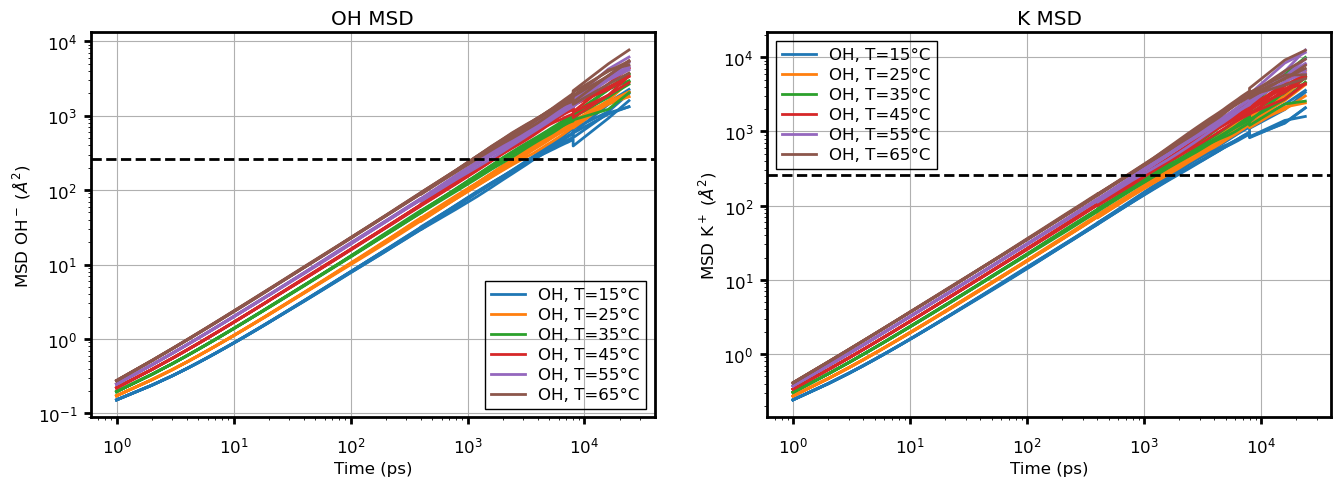

In [21]:
fig, axs = plt.subplots(1, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j, T_C in enumerate(Ts_C):
    labels = True
    for i, run in enumerate(runs):
        label = r"OH, T="+str(T_C)+r"°C" if labels else None
        labels = False
        axs[0].plot(t/1000, OH_msd[j][i], label=label, color=colors[j])
        axs[1].plot(t/1000, K_msd[j][i], label=label, color=colors[j])

axs[0].set_title("OH MSD")
axs[0].axhline(y=261, color='black', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel(r"MSD OH$^-$ ($\AA^2$)")
axs[0].grid()
axs[0].legend()

axs[1].set_title("K MSD")
axs[1].axhline(y=261, color='black', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel(r"MSD K$^+$ ($\AA^2$)")
axs[1].grid()
axs[1].legend()

In [22]:
OH_msd_log = np.vstack(OH_msd_log).T
np.savetxt("plot5/OH_msd_md.text", OH_msd_log, header=header, comments="")
K_msd_log = np.vstack(K_msd_log).T
np.savetxt("plot5/K_msd_md.text", K_msd_log, header=header, comments="")